In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
import BiGLasso_Methods as bg
import GmGM
import scipy.stats as stats
import scipy.sparse as sparse
import igraph as ig
import mean_wrapper as mw
import pandas as pd

import os

In [31]:
# Use pandas to read the csv `data/E-MTAB-2805/{STAGE}_singlecells_counts.txt`
data_g1 = pd.read_csv('data/E-MTAB-2805/G1_singlecells_counts.txt', sep='\t')
data_s = pd.read_csv('data/E-MTAB-2805/S_singlecells_counts.txt', sep='\t')
data_g2m = pd.read_csv('data/E-MTAB-2805/G2M_singlecells_counts.txt', sep='\t')

# Remove all rows with NaN values
data_g1 = data_g1.dropna()
data_s = data_s.dropna()
data_g2m = data_g2m.dropna()

data_g1

,EnsemblGeneID,EnsemblTranscriptID,AssociatedGeneName,GeneLength,G1_cell1_count,G1_cell2_count,G1_cell3_count,G1_cell4_count,G1_cell5_count,G1_cell6_count,...,G1_cell87_count,G1_cell88_count,G1_cell89_count,G1_cell90_count,G1_cell91_count,G1_cell92_count,G1_cell93_count,G1_cell94_count,G1_cell95_count,G1_cell96_count
0,ENSMUSG00000000001,ENSMUST00000000001,Gnai3,3262.0,43,82,5,0,2,87,...,329,0,364,80,774,4,308,13,372,137
1,ENSMUSG00000000003,ENSMUST00000000003,Pbsn,902.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000000028,ENSMUST00000000028,Cdc45,2143.0,89,598,10,249,135,36,...,26,1,499,410,935,6,666,1,29,499
3,ENSMUSG00000000031,ENSMUST00000136359,H19,2286.0,65,0,0,0,0,0,...,0,0,0,0,0,0,274,0,0,0
4,ENSMUSG00000000037,ENSMUST00000112345,Scml2,4847.0,1,0,0,0,0,391,...,912,0,30,216,2,16,0,645,154,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38288,ENSMUSG00000097931,ENSMUST00000181419,Gm11392,710.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38289,ENSMUSG00000097932,ENSMUST00000181148,AC160109.2,1033.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38290,ENSMUSG00000097933,ENSMUST00000180397,AC154675.1,522.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38291,ENSMUSG00000097934,ENSMUST00000181654,AC156980.1,1120.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
# Verify that the rows (genes) for all dataframes are in the same order
assert (data_g1['AssociatedGeneName'] == data_s['AssociatedGeneName']).all(), \
    "Not the same order!"
assert (data_g1['AssociatedGeneName'] == data_g2m['AssociatedGeneName']).all(), \
    "Not the same order!"

print("If this cell did not through an error, the rows (genes) for all dataframes are in the same order.")

If this cell did not through an error, the rows (genes) for all dataframes are in the same order.


In [33]:
# Check that gene names are distinct (if not, we should work with Transcript IDs or merge them)
data_g1['AssociatedGeneName'].value_counts()

U6               954
SNORA17          613
7SK              335
U1               210
5S_rRNA          208
                ... 
Rftn1              1
Clnk               1
AF529169           1
Ndst2              1
RP23-429I18.1      1
Name: AssociatedGeneName, Length: 34573, dtype: int64

In [34]:
# Verify that the rows (transcript ids) for all dataframes are in the same order
assert (data_g1['EnsemblTranscriptID'] == data_s['EnsemblTranscriptID']).all(), \
    "Not the same order!"
assert (data_g1['EnsemblTranscriptID'] == data_g2m['EnsemblTranscriptID']).all(), \
    "Not the same order!"

print("If this cell did not through an error, the transcripts for all dataframes are in the same order.")

If this cell did not through an error, the transcripts for all dataframes are in the same order.


In [35]:
# Load mythosis-related genes
mitosis_genes = pd.read_csv('data/E-MTAB-2805/Nmythosis.txt')
mitosis_genes

,EnsemblGeneID
0,ENSMUSG00000035439
1,ENSMUSG00000026426
2,ENSMUSG00000030105
3,ENSMUSG00000026491
4,ENSMUSG00000061665
...,...
162,ENSMUSG00000031010
163,ENSMUSG00000001403
164,ENSMUSG00000078762
165,ENSMUSG00000046010


In [36]:
# Keep only the genes in mitosis_genes
data_g1 = data_g1[data_g1['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]
data_s = data_s[data_s['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]
data_g2m = data_g2m[data_g2m['EnsemblGeneID'].isin(mitosis_genes['EnsemblGeneID'])]
data_g1

,EnsemblGeneID,EnsemblTranscriptID,AssociatedGeneName,GeneLength,G1_cell1_count,G1_cell2_count,G1_cell3_count,G1_cell4_count,G1_cell5_count,G1_cell6_count,...,G1_cell87_count,G1_cell88_count,G1_cell89_count,G1_cell90_count,G1_cell91_count,G1_cell92_count,G1_cell93_count,G1_cell94_count,G1_cell95_count,G1_cell96_count
128,ENSMUSG00000000743,ENSMUST00000000759,Chmp1a,2140.0,3,503,6,6,2,0,...,137,0,33,77,310,2,1,178,670,151
243,ENSMUSG00000001403,ENSMUST00000001439,Ube2c,2191.0,113,198,208,55,704,342,...,1055,0,109,1142,709,1084,549,502,233,829
327,ENSMUSG00000001833,ENSMUST00000115272,Sep-07,2533.0,513,1721,1477,439,813,689,...,1236,0,1556,1118,1271,430,1220,572,2177,951
369,ENSMUSG00000002055,ENSMUST00000045026,Spag5,3887.0,1,680,8,1,4,0,...,32,1,0,312,271,1,214,0,0,2563
821,ENSMUSG00000005233,ENSMUST00000126638,Spc25,1869.0,1578,739,558,141,100,182,...,195,0,35,457,339,114,393,140,1296,989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20634,ENSMUSG00000072980,ENSMUST00000110805,Oip5,1778.0,1,170,141,84,2,90,...,250,0,12,178,102,93,45,0,0,183
21179,ENSMUSG00000074476,ENSMUST00000098942,Spc24,1349.0,306,291,105,2,1679,108,...,1220,0,180,252,1153,943,773,177,1551,1116
23005,ENSMUSG00000078762,ENSMUST00000019697,Haus5,2187.0,0,1,45,0,0,0,...,0,0,4,7,75,0,4,7,28,0
23392,ENSMUSG00000079555,ENSMUST00000060049,Haus3,1950.0,41,27,29,1,7,12,...,231,0,159,43,129,91,1037,1377,2,302


In [37]:
# Drop `EnsemblGeneID`, `AssociatedGeneName`, and `GeneLength` columns
data_g1 = data_g1.drop(columns=['EnsemblGeneID', 'AssociatedGeneName', 'GeneLength'])
data_s = data_s.drop(columns=['EnsemblGeneID', 'AssociatedGeneName', 'GeneLength'])
data_g2m = data_g2m.drop(columns=['EnsemblGeneID', 'AssociatedGeneName', 'GeneLength'])

data_g1

,EnsemblTranscriptID,G1_cell1_count,G1_cell2_count,G1_cell3_count,G1_cell4_count,G1_cell5_count,G1_cell6_count,G1_cell7_count,G1_cell8_count,G1_cell9_count,...,G1_cell87_count,G1_cell88_count,G1_cell89_count,G1_cell90_count,G1_cell91_count,G1_cell92_count,G1_cell93_count,G1_cell94_count,G1_cell95_count,G1_cell96_count
128,ENSMUST00000000759,3,503,6,6,2,0,0,0,222,...,137,0,33,77,310,2,1,178,670,151
243,ENSMUST00000001439,113,198,208,55,704,342,852,1252,1268,...,1055,0,109,1142,709,1084,549,502,233,829
327,ENSMUST00000115272,513,1721,1477,439,813,689,586,899,1340,...,1236,0,1556,1118,1271,430,1220,572,2177,951
369,ENSMUST00000045026,1,680,8,1,4,0,0,431,2,...,32,1,0,312,271,1,214,0,0,2563
821,ENSMUST00000126638,1578,739,558,141,100,182,1703,715,55,...,195,0,35,457,339,114,393,140,1296,989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20634,ENSMUST00000110805,1,170,141,84,2,90,6,213,23,...,250,0,12,178,102,93,45,0,0,183
21179,ENSMUST00000098942,306,291,105,2,1679,108,450,116,2702,...,1220,0,180,252,1153,943,773,177,1551,1116
23005,ENSMUST00000019697,0,1,45,0,0,0,0,37,0,...,0,0,4,7,75,0,4,7,28,0
23392,ENSMUST00000060049,41,27,29,1,7,12,78,406,409,...,231,0,159,43,129,91,1037,1377,2,302


In [38]:
# Join the dataframes on EnsemblTranscriptID
data = data_g1.merge(data_s, on='EnsemblTranscriptID')
data = data.merge(data_g2m, on='EnsemblTranscriptID')
data

,EnsemblTranscriptID,G1_cell1_count,G1_cell2_count,G1_cell3_count,G1_cell4_count,G1_cell5_count,G1_cell6_count,G1_cell7_count,G1_cell8_count,G1_cell9_count,...,G2M_cell87_count,G2M_cell88_count,G2M_cell89_count,G2M_cell90_count,G2M_cell91_count,G2M_cell92_count,G2M_cell93_count,G2M_cell94_count,G2M_cell95_count,G2M_cell96_count
0,ENSMUST00000000759,3,503,6,6,2,0,0,0,222,...,21,384,4,879,998,130,126,195,0,153
1,ENSMUST00000001439,113,198,208,55,704,342,852,1252,1268,...,1655,2381,1125,3159,4706,1486,1203,2553,1302,1190
2,ENSMUST00000115272,513,1721,1477,439,813,689,586,899,1340,...,1403,1350,754,679,411,268,691,192,216,418
3,ENSMUST00000045026,1,680,8,1,4,0,0,431,2,...,1239,148,131,104,102,52,91,460,86,254
4,ENSMUST00000126638,1578,739,558,141,100,182,1703,715,55,...,1105,633,335,833,477,138,329,234,96,712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,ENSMUST00000110805,1,170,141,84,2,90,6,213,23,...,672,145,104,404,256,111,78,47,209,40
163,ENSMUST00000098942,306,291,105,2,1679,108,450,116,2702,...,1808,271,503,814,1503,575,248,224,533,647
164,ENSMUST00000019697,0,1,45,0,0,0,0,37,0,...,0,51,22,5,0,7,14,37,3,22
165,ENSMUST00000060049,41,27,29,1,7,12,78,406,409,...,449,179,85,84,271,123,138,119,9,153


In [39]:
# Convert to numpy format
data_array = np.log(data.drop(columns=['EnsemblTranscriptID']).to_numpy().astype(np.float64) + 1)
cell_names = data.columns[1:]
gene_names = data['EnsemblTranscriptID']

data_array, data_array.shape

(array([[1.38629436, 6.22257627, 1.94591015, ..., 5.27811466, 0.        ,
         5.0369526 ],
        [4.73619845, 5.29330482, 5.34233425, ..., 7.84541604, 7.17242458,
         7.08254857],
        [6.24222327, 7.45124168, 7.2984451 , ..., 5.26269019, 5.37989735,
         6.03787092],
        ...,
        [0.        , 0.69314718, 3.8286414 , ..., 3.63758616, 1.38629436,
         3.13549422],
        [3.73766962, 3.33220451, 3.40119738, ..., 4.78749174, 2.30258509,
         5.0369526 ],
        [6.02827852, 6.10479323, 6.09807428, ..., 5.34710753, 7.14755927,
         6.8134446 ]]),
 (167, 288))

In [40]:
# Create cell type labels
labels = np.zeros(data_array.shape[1], dtype='<U2')
labels_numeric = np.zeros(data_array.shape[1], dtype=int)
labels[cell_names.str.startswith('G1')] = 'G1'
labels[cell_names.str.startswith('S')] = 'S'
labels[cell_names.str.startswith('G2M')] = 'G2M'

# igraph's assortativity function requires labellings to be numeric
labels_numeric[cell_names.str.startswith('G1')] = 0
labels_numeric[cell_names.str.startswith('S')] = 1
labels_numeric[cell_names.str.startswith('G2M')] = 2
labels

array(['G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1',
       'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S',
       'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', '

In [41]:
dataset_gmgm = GmGM.Dataset(
    dataset={'data': data_array},
    structure={'data': (f'gene', f'cell')},
    batch_axes=None
)
results_gmgm = GmGM.GmGM(
    dataset_gmgm,
    to_keep=0.5,
    threshold_method="statistical-significance",
    n_comps=None,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results_gmgm

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...
Calculating eigenvectors for axis='gene'
Calculating eigenvectors for axis='cell'
100% explained variance, since `n_comps` was not specified
Calculating eigenvalues...
@0: -39594.49721673007 (-39598.23908931776 + 3.7418725876873125 + 0) ∆inf
Converged! (@13: -53434.78221721385)
Recomposing sparse precisions...


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Done!


Dataset(
	data: ('gene', 'cell')
)
Axes(
	gene: 167
		Prior: None
		Gram: Calculated
		Eig: Calculated
	cell: 288
		Prior: None
		Gram: Calculated
		Eig: Calculated
)

In [42]:
cell_graph_array = np.abs(results_gmgm.precision_matrices['cell'].toarray())
np.fill_diagonal(cell_graph_array, 0)
gmgm_assortativities = []

for percentage_to_keep in 10**np.linspace(-3, 0, 100):
    cg = cell_graph_array.copy()
    # Keep only the top `percentage_to_keep` edges
    threshold = np.percentile(cg, (1 - percentage_to_keep) * 100)
    cg[cg < threshold] = 0

    # Convert the cell graph object into an igraph object
    cell_graph = ig.Graph.Weighted_Adjacency(cg, mode=ig.ADJ_UNDIRECTED)
    cell_graph.vs['label'] = labels_numeric

    # Calculate assortativity
    gmgm_assortativities.append(cell_graph.assortativity_nominal('label'))

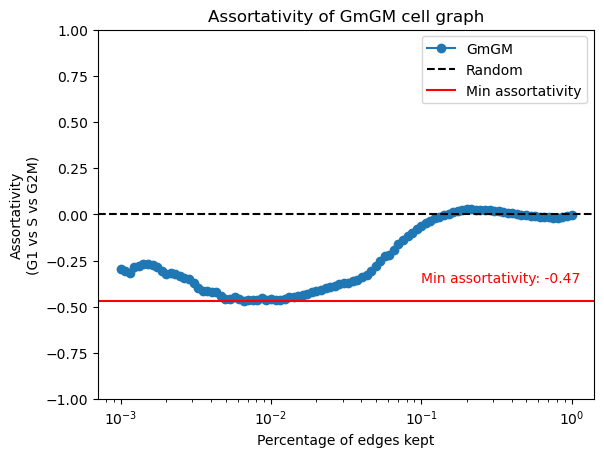

In [48]:
fig, ax = plt.subplots()
ax.plot(10**np.linspace(-3, 0, 100), gmgm_assortativities, marker='o', label='GmGM')
ax.set_xscale('log')
ax.axhline(0, color='black', linestyle='--', label='Random')
ax.set_xlabel('Percentage of edges kept')
ax.set_ylabel('Assortativity\n(G1 vs S vs G2M)')
ax.set_ylim(-1, 1)

# Add a line at the minimum assortativity
ax.axhline(min(gmgm_assortativities), color='red', linestyle='-', label='Min assortativity')
ax.text(
    0.1, min(gmgm_assortativities) + 0.1,
    f"Min assortativity: {min(gmgm_assortativities):.2f}",
    color='red'
)

ax.legend()
ax.set_title('Assortativity of GmGM cell graph')

fig.savefig('out-figs/cell-cycle/gmgm-assortativity.png')

In [44]:
dataset_gmgm_noncentral = GmGM.Dataset(
    dataset={'data': data_array},
    structure={'data': (f'gene', f'cell')},
    batch_axes=None
)
def gmgm_estimator(data):
    output = GmGM.GmGM(
        data,
        to_keep=0.5,
        threshold_method="statistical-significance",
        n_comps=None,
        verbose=False,
        centering_method=None,
        use_nonparanormal_skeptic=True,
        nonparanormal_evec_backend="COCA",
        readonly=False,
        calculate_explained_variance=True,
        batch_size=1000
    )
    return output.precision_matrices
NKS = mw.NoncentralKS(
    gmgm_estimator,
    ({"gene": np.zeros(167), "cell": np.zeros(288)}, 0),
    {"gene": np.eye(167), "cell": np.eye(288)},
)
class result_container:
    # Jerry-rigged class to hold the result
    def __init__(self, precmats):
        self.precision_matrices = precmats

means_gmgm_noncentral, results_gmgm_noncentral = NKS.fit(
    dataset_gmgm_noncentral,
    verbose=True,
    tol=1e-3,
    max_iter=10
)

Iteration: 1 (Change: 11.384046366278303)
Iteration: 2 (Change: 7.946399175549749)
Iteration: 3 (Change: 0.30064262874271186)
Iteration: 4 (Change: 0.015178711338208258)
Converged in 5 iterations
Iteration: 5 (Change: 0.0003344364327105381)


In [45]:
cell_graph_array = np.abs(results_gmgm_noncentral['cell'].toarray())
np.fill_diagonal(cell_graph_array, 0)
gmgm_noncentral_assortativities = []

for percentage_to_keep in 10**np.linspace(-3, 0, 100):
    cg = cell_graph_array.copy()
    # Keep only the top `percentage_to_keep` edges
    threshold = np.percentile(cg, (1 - percentage_to_keep) * 100)
    cg[cg < threshold] = 0

    # Convert the cell graph object into an igraph object
    cell_graph = ig.Graph.Weighted_Adjacency(cg, mode=ig.ADJ_UNDIRECTED)
    cell_graph.vs['label'] = labels_numeric

    # Calculate assortativity
    gmgm_noncentral_assortativities.append(cell_graph.assortativity_nominal('label'))

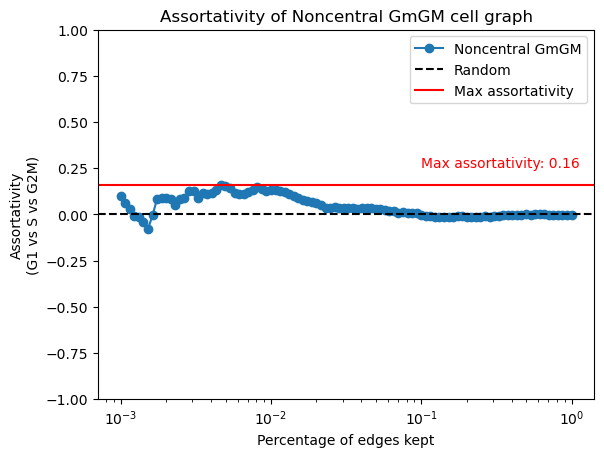

In [47]:
fig, ax = plt.subplots()
ax.plot(10**np.linspace(-3, 0, 100), gmgm_noncentral_assortativities, marker='o', label='Noncentral GmGM')
ax.set_xscale('log')
ax.axhline(0, color='black', linestyle='--', label='Random')
ax.set_xlabel('Percentage of edges kept')
ax.set_ylabel('Assortativity\n(G1 vs S vs G2M)')
ax.set_ylim(-1, 1)

# Add a line at the maximum assortativity, with a text label
ax.axhline(max(gmgm_noncentral_assortativities), color='red', linestyle='-', label='Max assortativity')
ax.text(
    0.1,
    max(gmgm_noncentral_assortativities) + 0.1,
    f'Max assortativity: {max(gmgm_noncentral_assortativities):.2f}',
    color='red'
)

ax.legend()
ax.set_title('Assortativity of Noncentral GmGM cell graph')

fig.savefig('out-figs/cell-cycle/gmgm_noncentral_assortativity.pdf', bbox_inches='tight')